In [1]:
# Base imports
import os
import sqlite3
from string import punctuation

# Data manimpulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

# Model preprocessing
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Transformers
from transformers import pipeline
from transformers import AutoTokenizer

In [2]:
############ FUNCTIONS ############
def find_params(X_train, y_train,
                clf,strip_accents=['unicode', None],min_df=[1,2,3,4,5],
                max_df=[0.3, 0.4, 0.5, 0.6, 0.7],
                ngram_range=[(1,1),(1,2),(1,3)],
                stop_words=[None, stopwords.words('english')],
                use_idf=(True, False),
                **kwargs):
    """Returns the optimal parameters from a grid search.
    
    Arguments
    X_train : X training data 
    y_train : y training data
    clf : a sklearn classifier
    stip_accents : TfidfVectorizer strip_accents parameter
    min_df : TfidfVectorizer min_df parameter
    max_df : TfidfVectorizer max_df parameter
    ngram_range : TfidfVectorizer ngram_range parameter
    stop_words : TfidfVectorizer stop_words parameter
    use_idf : TfidfVectorizer use_idf parameter
    **kwargs : optional model parameters
    """
    # Create Pipeline
    model_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', clf)
    ])

    # Create parameter space for TfidfVectorizer
    tfidf_params = {
            'tfidf__strip_accents': strip_accents,
            'tfidf__min_df': min_df,
            'tfidf__max_df': max_df,
            'tfidf__ngram_range': ngram_range,
            'tfidf__stop_words': stop_words,
            'tfidf__use_idf': use_idf,
    }

    # Create parameter space for classifier
    model_params = {}
    if kwargs:
        for k,v in kwargs.items():
            model_params['clf__'+k] = v

    # Create joined parameter space   
    pipeline_params = {**tfidf_params, **model_params}

    # Initialize grid search object
    gs_clf = GridSearchCV(model_pipeline, pipeline_params, scoring='f1_micro', 
                          cv=5, n_jobs=-1)

    # Fit grid search to training data
    gs_clf = gs_clf.fit(X_train, y_train)

    # Return results
    best_params = gs_clf.best_params_
    if best_params['tfidf__stop_words']:
        best_params['tfidf__stop_words'] = True
        
    return best_params


def build_model(X_train, y_train, X_test, y_test, clf, 
                strip_accents=None, stop_words=None, 
                ngram_range = (1,1), max_df=1, min_df=1, use_idf=True):
    """Build a model from training data. Returns a classification report and 
    confusion matrix based off of the testing data provided.
    
    Arguments
    X_train : X training data
    y_train : y training data
    X_test : X testing data
    y_test : y testing data
    clf : classification model
    strip_accents: TfidfVectorizer strip_accents parameter
    min_df : TfidfVectorizer min_df parameter
    max_df : TfidfVectorizer max_df parameter
    ngram_range : TfidfVectorizer ngram_range parameter
    stop_words : TfidfVectorizer stop_words parameter
    use_idf : TfidfVectorizer use_idf parameter
    """
    # Initialize vectorization parameters
    vectorizer = TfidfVectorizer(strip_accents=strip_accents,
                                 min_df=min_df,
                                 max_df=max_df,
                                 ngram_range=ngram_range,
                                 stop_words=stop_words,
                                 use_idf=use_idf)

    # Vectorize training and test data
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train classifier
    clf.fit(X_train_tfidf, y_train)

    # Predict of test data
    y_pred = clf.predict(X_test_tfidf)

    # Get classification report
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()
    
    return clf;


############ END FUNCTIONS ############

In [3]:
# Change directory
os.chdir('final project/CS254/data/')

# Load data
conn = sqlite3.connect('congress.db')
congress = pd.read_sql_query("SELECT * FROM congress", conn)
conn.close()

In [4]:
np.random.seed(1999)

# Extract just the sponsor party and bill summaries
df = congress[['sponsor_party', 'bill_summary']].copy()

# Remove the Libertarian and Independent parties
df = df[df['sponsor_party'] != 'L']
df = df[df['sponsor_party'] != 'I']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['bill_summary'],
                                                    df['sponsor_party'],
                                                    random_state=0,
                                                    test_size=0.2
                                                   )

## Multinomial Naive Bayes

In [8]:
find_params(X_train, y_train, MultinomialNB(), max_df=[0.39], min_df=[4], ngram_range=[(1,2)], strip_accents=['unicode'], use_idf=[True])

{'tfidf__max_df': 0.39,
 'tfidf__min_df': 4,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': True,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.72      0.88      0.79      2933
           R       0.79      0.56      0.66      2298

    accuracy                           0.74      5231
   macro avg       0.75      0.72      0.72      5231
weighted avg       0.75      0.74      0.73      5231



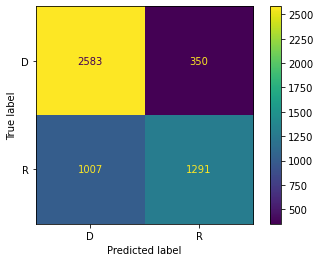

In [5]:
clf_nb = build_model(X_train, y_train, X_test, y_test,
                     MultinomialNB(),
                     max_df=0.39,
                     min_df=4,
                     ngram_range=(1,2),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True)

## Logistic Regression

In [16]:
find_params(X_train, y_train, LogisticRegression(max_iter=300), max_df=[0.48,0.5,0.52], min_df=[1,2], ngram_range=[(1,3)], use_idf=[True])

{'tfidf__max_df': 0.5,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': None,
 'tfidf__strip_accents': 'unicode',
 'tfidf__use_idf': True}

              precision    recall  f1-score   support

           D       0.76      0.84      0.80      2933
           R       0.77      0.67      0.71      2298

    accuracy                           0.77      5231
   macro avg       0.77      0.76      0.76      5231
weighted avg       0.77      0.77      0.76      5231



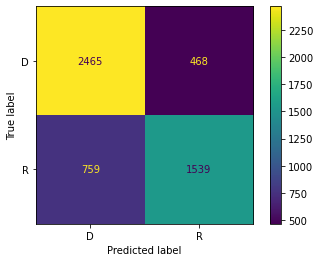

In [6]:
clf_lr = build_model(X_train, y_train, X_test, y_test,
                     LogisticRegression(max_iter=300),
                     max_df=0.5,
                     min_df=1,
                     ngram_range=(1,3),
                     stop_words=None,
                     strip_accents='unicode',
                     use_idf=True
                    )

## Support Vector Classification (SVC)

In [ ]:
find_params(X_train, y_train, SVC(), kernel=['poly', 'rbf', 'sigmoid'], gamma=['auto', 'scale'])

              precision    recall  f1-score   support

           D       0.80      0.85      0.82      2933
           R       0.79      0.72      0.75      2298

    accuracy                           0.79      5231
   macro avg       0.79      0.79      0.79      5231
weighted avg       0.79      0.79      0.79      5231



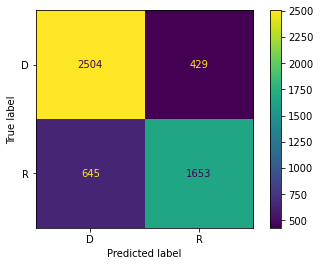

In [10]:
clf_svc = build_model(X_train, y_train, X_test, y_test,
                      SVC(kernel='rbf',
                          gamma='scale',
                          probability=True
                         ),
                      max_df=0.5,
                      min_df=5,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

              precision    recall  f1-score   support

           D       0.79      0.86      0.82      2933
           R       0.79      0.72      0.75      2298

    accuracy                           0.79      5231
   macro avg       0.79      0.79      0.79      5231
weighted avg       0.79      0.79      0.79      5231



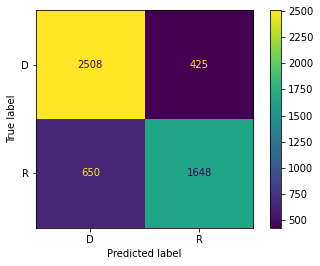

In [8]:
clf_svc = build_model(X_train, y_train, X_test, y_test,
                      SVC(kernel='rbf',
                          gamma='scale',
                          probability=True
                         ),
                      max_df=0.1,
                      min_df=5,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

## SGD Classifier

In [ ]:
find_params(X_train, y_train, SGDClassifier(n_jobs=-1, loss=['log', 'hinge']))

              precision    recall  f1-score   support

           D       0.75      0.83      0.79      2933
           R       0.75      0.65      0.70      2298

    accuracy                           0.75      5231
   macro avg       0.75      0.74      0.74      5231
weighted avg       0.75      0.75      0.75      5231



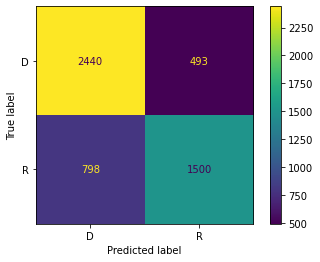

In [18]:
clf_sgd = build_model(X_train, y_train, X_test, y_test,
                      SGDClassifier(n_jobs=-1, loss='hinge'
                                   ),
                      max_df=0.5,
                      min_df=5,
                      ngram_range=(1,3),
                      stop_words=stopwords.words('english'),
                      strip_accents='unicode',
                      use_idf=True
                     )

## Random Forest

In [ ]:
find_params(X_train, y_train, RandomForestClassifier(),
            max_features=['auto', 'sqrt', 'log2'],
            criterion=['gini', 'entropy'],
            max_depth=[None, 3, 5, 10])

              precision    recall  f1-score   support

           D       0.78      0.86      0.82      2933
           R       0.80      0.69      0.74      2298

    accuracy                           0.79      5231
   macro avg       0.79      0.78      0.78      5231
weighted avg       0.79      0.79      0.78      5231



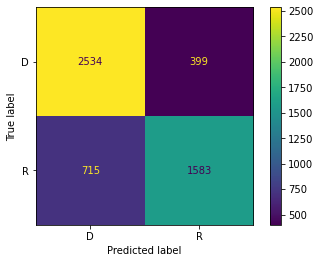

In [36]:
clf_rf = build_model(X_train, y_train, X_test, y_test,
                     RandomForestClassifier(max_features='auto',
                                            criterion='gini'
                                           ),
                     max_df=0.1,
                     min_df=5,
                     ngram_range=(1,2),
                     stop_words=stopwords.words('english'),
                     strip_accents='unicode',
                     use_idf=True
                    )

# Transformers

Now we will look at using name entity recognition provided by the hugging face library

In [4]:
summarizer = pipeline("summarization")
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 (https://huggingface.co/sshleifer/distilbart-cnn-12-6)


In [170]:
def text_len(text):
    """Return the minimum and maximum length of a body of text
    for input in a tranformer model.
    """
    tokenized_text = tokenizer(text)
    text_length = len(tokenized_text['input_ids'])
    min_len = 1
    max_len = int(np.ceil(text_length * 0.3))
    
    return text_length, min_len, max_len

In [181]:
hf_summarizer = []
n = 3000
for text in congress['bill_summary']:
    text_length, min_len, max_len = text_len(text)
    if text_length <= 1024:
        hf_summarizer.append(summarizer(text, min_length=min_len, max_length=max_len)[0]['summary_text'])
    
    # Text is too long, needs to be broken up to run
    else:
        summarized_text = []
        for i in range(int(np.ceil(len(text) / n))):
            partial_text = text[i*n:(i+1)*n]
            _,_,max_len = text_len(partial_text)
            summarized_text.append(summarizer(partial_text,
                                              min_length=min_len,
                                              max_length=max_len)[0]['summary_text'])
        hf_summarizer.append("".join(summarized_text))

In [186]:
congress['hf_summary'] = hf_summarizer

In [189]:
congress.to_csv("hf_summary.csv", index=False)

https://billmap.govtrack.us/bills/114hr3682